# 필요한 라이브러리 설치 및 import

In [ ]:
!pip install surprise

In [ ]:
from surprise import Dataset, Reader
from surprise import SVD
from surprise import KNNBasic
from google.colab import drive
from surprise import accuracy
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import multiprocessing
import warnings
warnings.filterwarnings("ignore")

# 데이터 준비

데이터 불러오기

In [ ]:
user_movie_df = pd.read_csv('/content/drive/MyDrive/SSAC/4조/코드/Dataset/2019 movie/rating_movie_opt2.csv')
user_movie_df.shape

(982121, 7)

In [ ]:
user_movie_df = user_movie_df[-100000:]
user_movie_df.shape

(100000, 7)

In [ ]:
user_movie_df.head()

,movieId,rating,timestamp,title,genres,year,userId
882121,71535,2.0,1319325123,Zombieland (2009),Action|Comedy|Horror,2009,28742
882122,71535,3.5,1376151921,Zombieland (2009),Action|Comedy|Horror,2009,15963
882123,71535,5.0,1489259849,Zombieland (2009),Action|Comedy|Horror,2009,93135
882124,71535,5.0,1318187352,Zombieland (2009),Action|Comedy|Horror,2009,56452
882125,71535,3.0,1345174137,Zombieland (2009),Action|Comedy|Horror,2009,72120


In [ ]:
user_movie_df['userId'] = user_movie_df['userId'].astype('category').cat.codes.values + 1
user_movie_df['movieId'] = user_movie_df['movieId'].astype('category').cat.codes.values + 1

In [ ]:
user_movie_df.head()

,movieId,rating,timestamp,title,genres,year,userId
882121,1,2.0,1319325123,Zombieland (2009),Action|Comedy|Horror,2009,325
882122,1,3.5,1376151921,Zombieland (2009),Action|Comedy|Horror,2009,188
882123,1,5.0,1489259849,Zombieland (2009),Action|Comedy|Horror,2009,1032
882124,1,5.0,1318187352,Zombieland (2009),Action|Comedy|Horror,2009,641
882125,1,3.0,1345174137,Zombieland (2009),Action|Comedy|Horror,2009,806


In [ ]:
user_movie_df = user_movie_df.sort_values(by='userId')
user_movie_df

,movieId,rating,timestamp,title,genres,year,userId
922929,214,4.5,1346231333,Jiro Dreams of Sushi (2011),Documentary,2011,1
901869,104,3.0,1327220235,Harry Potter and the Deathly Hallows: Part 1 (...,Action|Adventure|Fantasy|IMAX,2010,1
886455,21,4.0,1285210981,Sherlock Holmes (2009),Action|Crime|Mystery|Thriller,2009,1
911665,160,4.5,1319312775,Horrible Bosses (2011),Comedy|Crime,2011,1
897354,81,2.0,1286094911,Scott Pilgrim vs. the World (2010),Action|Comedy|Fantasy|Musical|Romance,2010,1
...,...,...,...,...,...,...,...
890956,49,3.5,1281407573,Dogtooth (Kynodontas) (2009),Drama,2009,1800
897565,84,4.0,1297812070,Machete (2010),Action|Adventure|Comedy|Crime|Thriller,2010,1800
913912,168,1.5,1329514370,Rise of the Planet of the Apes (2011),Action|Drama|Sci-Fi|Thriller,2011,1800
883076,7,4.0,1280920671,Fantastic Mr. Fox (2009),Adventure|Animation|Children|Comedy|Crime,2009,1800


In [ ]:
# unique() 함수로 사용자 수와 영화 수 탐색
len(user_movie_df['userId'].unique())

1800

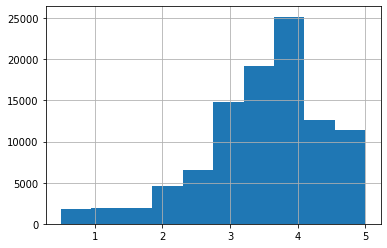

In [ ]:
# hist() 함수로 히스토그램 그래프 생성
user_movie_df['rating'].hist() #점수 분포 확인

# Suprise

## 데이터 준비

사이킷런 train_test_split으로 train/test set 분리

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(user_movie_df, test_size=0.2, random_state=4)

In [ ]:
drop_list = []
for u in test.userId.unique():
    if u not in train.userId.unique():
        drop_list.append(u)
test = test.set_index('userId').drop(drop_list).reset_index()

사이킷런에서 나눈 데이터 surprise 형식에 맞게 변환

In [ ]:
# # Reader, Dataset 오브젝트로 학습용 데이터셋 생성 및 분리
reader = Reader(rating_scale = (1,5)) # Reader: 레이팅 테이블을 분석하기 위한 클래스. user ; item ; rating ; [timestamp] 이런 구조로 된 테이블을 써야함. (1,5) : 레이팅 점수 범위
data = Dataset.load_from_df(user_movie_df[['userId', 'movieId', 'rating']], reader) #Dataset: 데이터 관리하는 클래스. 위에서 읽은 데이터중 시간을 빼고 읽음
# 불러온 레이팅 데이터를 학습테스트 데이터 80프로 테스트 데이터 20프로로 분리
# train 데이터 프레임을 surprise.trainset 형식으로 변환
trainset = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader).build_full_trainset()
test_data = trainset.build_anti_testset()
 # 형식에 맞게 test set 생성
testset = []
for i in range(len(test)):
    testset.append((test['userId'].iloc[i], test['movieId'].iloc[i], test['rating'].iloc[i]))

### map 계산하는 함수 정의

In [ ]:
# k를 인자로 받아 3개의 추천 후보를 담는 user metric 로 mean average precision 계산하는 함수 (위에 두부분을 합친것)
def get_map(k,predictions):

  estimated_unwatched_dict = {} 
  for uid, iid, _, predicted_rating, _ in predictions:
    if uid in estimated_unwatched_dict:
      estimated_unwatched_dict[uid].append((iid, predicted_rating))
    else:
      estimated_unwatched_dict[uid] = [(iid, predicted_rating)]

# test 데이터 중에 4점 이상 평가 된 영화들중에
# 각 유저별로 4점이상 평가한 영화들에 대한 리스트를 만든다
  user_watch_dict_list = test[test['rating']>0].groupby('userId')[['userId', 'movieId']].apply(lambda x: x['movieId'].tolist())
  

  user_metric = []
  for user in estimated_unwatched_dict:
    estimated_list = estimated_unwatched_dict[user].copy()
    estimated_list.sort(key=lambda tup: tup[1], reverse=True)#tup[1] 점수에 해당하는 부분. reverse -> 내림차순
    #유저별 영화에 대한 예측평가점수들을 내림차순으로 정렬함 (리스트가 점수에따라 정렬이 됨)
    try: 
      top_k_prefer_list = [movie[0] for movie in estimated_list[:k]] #유저별로 높게 평가했을거라고 예측된 상위 k의 영화를 가져옴
      actual_watch_list = user_watch_dict_list[int(user)] #실제로 본 영화평가중 4점 이상으로 평가한것
      user_metric.append((user, top_k_prefer_list, actual_watch_list)) # '유저'별로 '예측된 평가중 상위 k개'와 '실제로 4점이상준 영화'를 짝지어 user_metric 리스트에 튜플로 넣어줌
    except: #특정시점 이전엔 영화를 봤지만 특정시점 이후에는 영화를 안본 유저를 걸러주기 위함
      pass
  
  precision_list = []
  for user in user_metric:
    predictive_values = user[1] #높게 평가했을 거라고 예측한 상위 k개 영화중 하나
    actual_values = set(user[2]) #유저가 실제로 4점이상이라고 평가한 영화
    tp = [pv for pv in predictive_values if pv in actual_values] #Confusion Matrix를 통한 precision 계산1
    precision = len(tp) / len(predictive_values) ##Confusion Matrix를 통한 precision 계산2 여기서 나온값 ex) 0.33 -> 추천한 3개중 1개는 만족했다
    precision_list.append(precision) #각 유저별 precision 값을 저장
  return sum(precision_list) / len(precision_list) #유저 전반적으로 만족함을 평가한 값 -> 0.1449 -> 100개를 추천했다고 치면 14정도는 만족을 했다


## KNN 학습

In [ ]:
# KNNBasic 모델 학습
algo = KNNBasic(k = 30, min_k = 3, sim_options={'user_based': True, 'name':'cosine'}) #sim_options. itembase 또는 user base, 어떤 방식으로 유사도 찾을지
algo.fit(trainset)
pred_test = algo.test(testset) # 각 유저별로 아직 안본 영화들의 평점 예측
accuracy.fcp(pred_test)  # FCP를 구해 평가
accuracy.rmse(pred_test) # RMSE를 구해 평가

pred_all = mf_model.test(test_data)
map_score = round(get_map(k,pred_all),4) # MAP를 구해 평가
print(f'MAP@10: {map_score}')


Computing the cosine similarity matrix...
Done computing similarity matrix.
FCP:  0.6637
RMSE: 0.9545
MAP@10: 0.0201


In [ ]:
# KNNBasic 모델 학습
algo = KNNBasic(k = 30, min_k = 3, sim_options={'user_based': True, 'name':'cosine'}) #sim_options. itembase 또는 user base, 어떤 방식으로 유사도 찾을지
algo.fit(trainset)
pred_test = algo.test(testset) # 각 유저별로 아직 안본 영화들의 평점 예측

Computing the cosine similarity matrix...
Done computing similarity matrix.


### 테스트 셋과 예측 비교 - KNN

In [ ]:
for uid, iid, real, pred, _ in pred_test:
    if uid == 10:
        print(f'- 유저 {uid}의 {iid}번 영화에 대한 평점 -')
        print(f'실제 : {real}, 예측 : {round(pred,1)}\n')

- 유저 10의 18번 영화에 대한 평점 -
실제 : 4.0, 예측 : 3.6

- 유저 10의 20번 영화에 대한 평점 -
실제 : 3.5, 예측 : 3.4

- 유저 10의 88번 영화에 대한 평점 -
실제 : 4.0, 예측 : 3.7

- 유저 10의 110번 영화에 대한 평점 -
실제 : 3.5, 예측 : 3.1



### SVD 학습

In [ ]:
# SVD 모델 학습
n = 10 # latent factor
k = 10 # 영화를 몇개나 추천할지

mf_model = SVD(n_factors=n) #Latent Factor N개로 측정
mf_model.fit(trainset) #학습하기
pred_test = mf_model.test(testset) # 각 유저별로 아직 안본 영화들의 평점 예측

In [ ]:
# 학습
n = 10 # latent factor
k = 10 # 영화를 몇개나 추천할지

mf_model = SVD(n_factors=n) #Latent Factor N개로 측정
mf_model.fit(trainset) #학습하기
pred_test = mf_model.test(testset) # 각 유저별로 아직 안본 영화들의 평점 예측
accuracy.fcp(pred_test)
accuracy.rmse(pred_test) #RMSE를 구해 평가
#print(f'RMSE: {rmse_score}')
pred_all = mf_model.test(test_data)
map_score = round(get_map(k,pred_all),4)
print(f'MAP@10: {map_score}')


FCP:  0.6732
RMSE: 0.8050
MAP@10: 0.0201


### 테스트 셋과 예측 비교 - SVD

In [ ]:
for uid, iid, real, pred, _ in pred_test:
    if uid == 10:
        print(f'- 유저 {uid}의 {iid}번 영화에 대한 평점 -')
        print(f'실제 : {real}, 예측 : {round(pred,1)}\n')

- 유저 10의 18번 영화에 대한 평점 -
실제 : 4.0, 예측 : 3.9

- 유저 10의 20번 영화에 대한 평점 -
실제 : 3.5, 예측 : 3.8

- 유저 10의 88번 영화에 대한 평점 -
실제 : 4.0, 예측 : 4.0

- 유저 10의 110번 영화에 대한 평점 -
실제 : 3.5, 예측 : 3.4



### 최적의 latent factor 찾기

In [ ]:
%time
#Latent Factor 수를 조절하여 최상의 학습결과를 내는것을 찾음 -> 더많은 후보군
#param_list = [x for x in range(5,100,5)] #Latent Factor 후보군
param_list = range(5,30,5)
fcp_list = []
rmse_list = []
map_list = []
for n in param_list:    
    train_start = time.time() #학습에 걸린 시간을 측정하기위함
    print(f'latent factor: {n}')
    mf_model = SVD(n_factors=n) #Latent Factor N개로 측정
    mf_model.fit(trainset) #학습하기
    
    # 테스트 셋에서 평점을 얼마나 잘 예측했는지
    pred_test = mf_model.test(testset) 
    fcp_list.append(accuracy.fcp(pred_test))
    rmse_list.append(accuracy.rmse(pred_test)) #RMSE를 구해 평가

    # 각 유저별로 아직 안본 영화들의 평점 예측
    pred_all = mf_model.test(test_data) 
    map_score = round(get_map(k,pred_all),4) # MAP 점수 계산(k=10개 추천할때에)
    map_list.append(map_score)  
    print(f'MAP@10: {map_score}')
    print("------------------------------------")
print("searching n_factors is finish.")

# #범위를 좁혀 했을때 15개가 성능이 제일 좋았다

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs
latent factor: 5
FCP:  0.6679
RMSE: 0.8067
MAP@10: 0.0193
------------------------------------
latent factor: 10
FCP:  0.6746
RMSE: 0.8016
MAP@10: 0.0222
------------------------------------
latent factor: 15
FCP:  0.6688
RMSE: 0.8045
MAP@10: 0.0203
------------------------------------
latent factor: 20
FCP:  0.6689
RMSE: 0.8051
MAP@10: 0.0225
------------------------------------
latent factor: 25
FCP:  0.6686
RMSE: 0.8052
MAP@10: 0.0207
------------------------------------
searching n_factors is finish.


#### Latent Factor에 따른 평가 확인

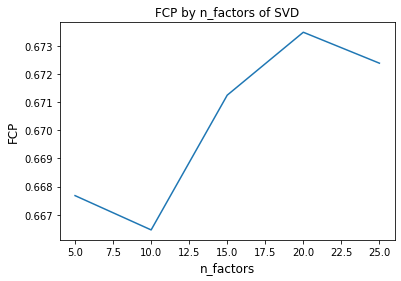

In [ ]:
#위에 5~200개 중 5단위로 있는 Latent Factor들 중 가장 성능이 좋은것을 찾음 
plt.plot(param_list, fcp_list) 
plt.title('FCP by n_factors of SVD')
plt.ylabel('FCP', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

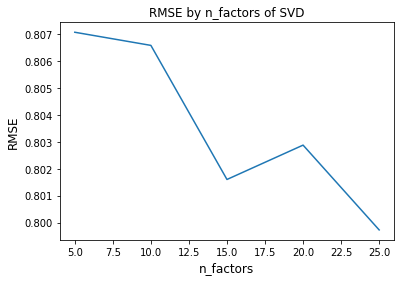

In [ ]:
#위에 5~200개 중 5단위로 있는 Latent Factor들 중 가장 성능이 좋은것을 찾음 
plt.plot(param_list, rmse_list) 
plt.title('RMSE by n_factors of SVD')
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

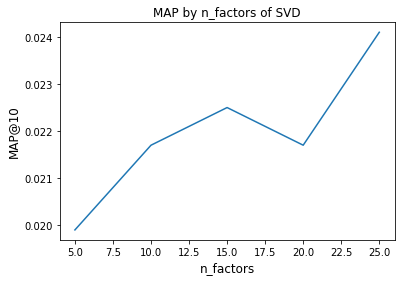

In [ ]:
#위에 5~200개 중 5단위로 있는 Latent Factor들 중 가장 성능이 좋은것을 찾음 
plt.plot(param_list, map_list) 
plt.title('MAP by n_factors of SVD')
plt.ylabel('MAP@10', fontsize=12)
plt.xlabel('n_factors', fontsize=12)
plt.show()

## 시간순으로 데이터 나눠서 학습

In [ ]:
###################################################################################################
#                               시간순으로 데이터를 나눠 학습해보기                               #
###################################################################################################

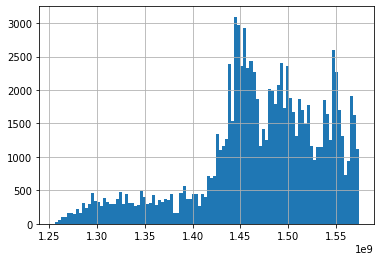

In [ ]:
user_movie_df['timestamp'].hist(bins=100); #유져별 각 영화 시청 시간의 분포를 알아보기

In [ ]:
# Quantile을 통해 전체 시간대 중 과거 80프로 미래 20프로로 나누는 특정 시간을 찾는다
that_time = user_movie_df['timestamp'].quantile(q=0.8, interpolation='nearest')
that_time

1533058781

In [ ]:
# 위에서 찾은 특정 시간으로 데이터를 나눈다
# 데이터를 8대 2로 나누는 시간이므로
# 전체데이터중 학습용 80프로 테스트용 20프로로 나뉜다
past_df = user_movie_df[user_movie_df['timestamp']< that_time][['userId','movieId','rating']]
future_df = user_movie_df[user_movie_df['timestamp'] >= that_time][['userId','movieId','rating']]

#여기서 과거용 데이터를 기준으로 위에서 한것처럼 학습을 시키고
#과거용 데이터에서 채워넣은 값들 (미래에 대한걸 예측한 값) 이랑 실제 미래값이랑 비교해본다.

In [ ]:
past_df.shape #총 8만개의 시청 기록

(79999, 3)

In [ ]:
len(past_df['userId'].unique()), len(future_df['userId'].unique()) #학습엔 547명의 유저, #테스트엔 147명의 유저

(1579, 469)

In [ ]:
future_data = []
for i in range(len(test)):
    future_data.append((future_df['userId'].iloc[i], future_df['movieId'].iloc[i], future_df['rating'].iloc[i]))

## 시간순으로 학습

In [ ]:
# 위 For문에서 얻은 최적의 Latent Factor의 수로 학습
# 위에서 추출한 학습 데이터셋으로 SVD 모델 다시 학습
data = Dataset.load_from_df(df = past_df, reader = reader) #과거 데이터를 불러오기
train_data = data.build_full_trainset() #과거데이터에서 랜덤으로 학습할 것을 뽑음
test_data = train_data.build_anti_testset() # anti dataset 생성 -> 윗줄코드 과거데이터에서 학습데이터를 뽑은걸 바탕으로 테스트데이터를 추출
mf_model = SVD(n_factors = 50) ######################이전에 이 가장 학습성능이 좋아서 10으로 진행########################
mf_model.fit(train_data)


In [ ]:
future_predictions = mf_model.test(future_data) #과거데이터에서 뽑은 학습데이터로 학습한걸로 과거데이터에서 뽑은 테스트데이터를 적용시켜봄
predictions = mf_model.test(test_data)

In [ ]:
for uid, iid, real, pred, _ in future_predictions:
    if uid ==40:
        print(f'- 유저 {uid}의 {iid}번 영화에 대한 평점 -')
        print(f'실제 : {real}, 예측 : {round(pred,1)}\n')

- 유저 40의 581번 영화에 대한 평점 -
실제 : 4.0, 예측 : 3.0

- 유저 40의 441번 영화에 대한 평점 -
실제 : 3.0, 예측 : 3.3

- 유저 40의 442번 영화에 대한 평점 -
실제 : 3.5, 예측 : 3.1

- 유저 40의 439번 영화에 대한 평점 -
실제 : 3.5, 예측 : 3.3

- 유저 40의 571번 영화에 대한 평점 -
실제 : 4.0, 예측 : 3.2



# MF - sklearn (SVD, SGD, ALS)

## 학습 준비

### rating matrix 만들기

In [ ]:
# user - movie 데이터프레임 생성
user_movie_rating = train.pivot_table('rating', index = 'userId', columns='title').fillna(0)
user_movie_rating.head()

title,10 Cloverfield Lane (2016),12 Years a Slave (2013),127 Hours (2010),2 Guns (2013),2012 (2009),21 Jump Street (2012),22 Jump Street (2014),3 Idiots (2009),300: Rise of an Empire (2014),50/50 (2011),A Million Ways to Die in the West (2014),A Quiet Place (2018),"A-Team, The (2010)",About Time (2013),Abraham Lincoln: Vampire Hunter (2012),"Adjustment Bureau, The (2011)","Adventures of Tintin, The (2011)",After Earth (2013),Alice in Wonderland (2010),Alien: Covenant (2017),"Amazing Spider-Man, The (2012)",American Hustle (2013),American Reunion (American Pie 4) (2012),American Sniper (2014),"American, The (2010)",Anchorman 2: The Legend Continues (2013),Annihilation (2018),Another Earth (2011),Ant-Man (2015),Ant-Man and the Wasp (2018),Argo (2012),Arrival (2016),Atomic Blonde (2017),Attack the Block (2011),Avatar (2009),"Avengers, The (2012)",Avengers: Age of Ultron (2015),Avengers: Infinity War - Part I (2018),Avengers: Infinity War - Part II (2019),Baby Driver (2017),...,Untitled Spider-Man Reboot (2017),Up in the Air (2009),Upgrade (2018),Valentine's Day (2010),Valerian and the City of a Thousand Planets (2017),Wall Street: Money Never Sleeps (2010),War Dogs (2016),War for the Planet of the Apes (2017),Warcraft (2016),Warm Bodies (2013),Warrior (2011),"Way, Way Back, The (2013)",We Bought a Zoo (2011),We Need to Talk About Kevin (2011),We're the Millers (2013),What We Do in the Shadows (2014),Where the Wild Things Are (2009),Whiplash (2013),Whiplash (2014),White House Down (2013),Wild (2014),Wild Tales (2014),Win Win (2011),"Wind Rises, The (Kaze tachinu) (2013)",Wind River (2017),Winter's Bone (2010),"Wolf of Wall Street, The (2013)","Wolverine, The (2013)",Wonder Woman (2017),World War Z (2013),"World's End, The (2013)",Wreck-It Ralph (2012),X-Men: Apocalypse (2016),X-Men: Days of Future Past (2014),X-Men: First Class (2011),Your Name. (2016),Youth in Revolt (2009),Zero Dark Thirty (2012),Zombieland (2009),Zootopia (2016)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,4.5,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.5


In [ ]:
# user - movie 데이터 프레임을 행렬로 변환
rating_matrix = user_movie_rating.values
rating_matrix.shape

(1788, 581)

### id에 해당하는 인덱스 찾는 딕셔너리 생성

In [ ]:
user2idx = {}
for i, l in enumerate(train['userId'].unique()):
    user2idx[l] = i
    
movie2idx = {}
for i, l in enumerate(train['movieId'].unique()):
    movie2idx[l] = i
idx2user = {i: user for user, i in user2idx.items()}
idx2movie = {i: item for item, i in movie2idx.items()}

## SVD

- 학습 진행

In [ ]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds

SVD_sk = TruncatedSVD(n_components=12)

- 다른 방식들과 통일을 위해 matrix 생성, 저장

In [ ]:
left = SVD_sk.fit_transform(rating_matrix)
right = SVD_sk.components_
sing = np.diag(SVD_sk.explained_variance_)

In [ ]:
print(f'left : {left.shape}, sing : {sing.shape},  right : {right.shape}')

left : (1788, 12), sing : (12, 12),  right : (12, 581)


In [ ]:
svd_matrix = left.dot(sing).dot(right)
svd_matrix.shape

(1788, 581)

In [ ]:
# 모델 저장
# path = ''
# np.save(path + 'svd', svd_matrix)

## SGD

### SGD 함수 정의



In [ ]:
from tqdm import tqdm_notebook as tqdm

# Base code : https://yamalab.tistory.com/92
class MatrixFactorization():
    def __init__(self, R, k, learning_rate, reg_param, epochs, verbose=False):
        """
        :param R: rating matrix
        :param k: latent parameter
        :param learning_rate: alpha on weight update
        :param reg_param: beta on weight update
        :param epochs: training epochs
        :param verbose: print status
        """
        self._R = R
        self._num_users, self._num_items = R.shape
        self._k = k
        self._learning_rate = learning_rate
        self._reg_param = reg_param
        self._epochs = epochs
        self._verbose = verbose


    def fit(self):
        """
        training Matrix Factorization : Update matrix latent weight and bias

        참고: self._b에 대한 설명
        - global bias: input R에서 평가가 매겨진 rating의 평균값을 global bias로 사용
        - 정규화 기능. 최종 rating에 음수가 들어가는 것 대신 latent feature에 음수가 포함되도록 해줌.

        :return: training_process
        """

        # init latent features
        self._P = np.random.normal(size=(self._num_users, self._k))
        self._Q = np.random.normal(size=(self._num_items, self._k))

        # init biases
        self._b_P = np.zeros(self._num_users)
        self._b_Q = np.zeros(self._num_items)
        self._b = np.mean(self._R[np.where(self._R != 0)])

        # train while epochs
        self._training_process = []
        for epoch in range(self._epochs):
            # rating이 존재하는 index를 기준으로 training
            xi, yi = self._R.nonzero()
            for i, j in zip(xi, yi):
                self.gradient_descent(i, j, self._R[i, j])
            cost = self.cost()
            self._training_process.append((epoch, cost))

            # print status
            if self._verbose == True and ((epoch + 1) % 10 == 0):
                print("Iteration: %d ; cost = %.4f" % (epoch + 1, cost))


    def cost(self):
        """
        compute root mean square error
        :return: rmse cost
        """

        # xi, yi: R[xi, yi]는 nonzero인 value를 의미한다.
        # 참고: http://codepractice.tistory.com/90
        xi, yi = self._R.nonzero()
        # predicted = self.get_complete_matrix()
        cost = 0
        for x, y in zip(xi, yi):
            cost += pow(self._R[x, y] - self.get_prediction(x, y), 2)
        return np.sqrt(cost/len(xi))


    def gradient(self, error, i, j):
        """
        gradient of latent feature for GD

        :param error: rating - prediction error
        :param i: user index
        :param j: item index
        :return: gradient of latent feature tuple
        """

        dp = (error * self._Q[j, :]) - (self._reg_param * self._P[i, :])
        dq = (error * self._P[i, :]) - (self._reg_param * self._Q[j, :])
        return dp, dq


    def gradient_descent(self, i, j, rating):
        """
        graident descent function

        :param i: user index of matrix
        :param j: item index of matrix
        :param rating: rating of (i,j)
        """

        # get error
        prediction = self.get_prediction(i, j)
        error = rating - prediction

        # update biases
        self._b_P[i] += self._learning_rate * (error - self._reg_param * self._b_P[i])
        self._b_Q[j] += self._learning_rate * (error - self._reg_param * self._b_Q[j])

        # update latent feature
        dp, dq = self.gradient(error, i, j)
        self._P[i, :] += self._learning_rate * dp
        self._Q[j, :] += self._learning_rate * dq


    def get_prediction(self, i, j):
        """
        get predicted rating: user_i, item_j
        :return: prediction of r_ij
        """
        return self._b + self._b_P[i] + self._b_Q[j] + self._P[i, :].dot(self._Q[j, :].T)


    def get_complete_matrix(self):
        """
        computer complete matrix PXQ + P.bias + Q.bias + global bias

        - PXQ 행렬에 b_P[:, np.newaxis]를 더하는 것은 각 열마다 bias를 더해주는 것
        - b_Q[np.newaxis:, ]를 더하는 것은 각 행마다 bias를 더해주는 것
        - b를 더하는 것은 각 element마다 bias를 더해주는 것

        - newaxis: 차원을 추가해줌. 1차원인 Latent들로 2차원의 R에 행/열 단위 연산을 해주기위해 차원을 추가하는 것.

        :return: complete matrix R^
        """
        return self._b + self._b_P[:, np.newaxis] + self._b_Q[np.newaxis:, ] + self._P.dot(self._Q.T)

### 학습

### rating matrix를 sparse matrix로

In [ ]:
data = train[['userId', 'movieId']]#.reset_index(drop=True)
useridx = data['useridx'] = train['userId'].apply(lambda x: user2idx[x]).values
movieidx = data['movieId'] = train['movieId'].apply(lambda x: movie2idx[x]).values
rating = train['rating']

rating_sparse = scipy.sparse.csr_matrix((rating, (useridx, movieidx)), shape=(len(set(useridx)), len(set(movieidx))))

rating_matrix = rating_sparse.toarray()

### SGD 학습

In [ ]:
%%time
factorizer = MatrixFactorization(rating_matrix, k = 10, learning_rate=0.1, reg_param=0.1, epochs=100, verbose=True)
factorizer.fit()

Iteration: 10 ; cost = 0.7320
Iteration: 20 ; cost = 0.7118
Iteration: 30 ; cost = 0.7071
Iteration: 40 ; cost = 0.7042
Iteration: 50 ; cost = 0.7027
Iteration: 60 ; cost = 0.7019
Iteration: 70 ; cost = 0.7016
Iteration: 80 ; cost = 0.7015
Iteration: 90 ; cost = 0.7014
Iteration: 100 ; cost = 0.7013
CPU times: user 4min 24s, sys: 23.4 s, total: 4min 47s
Wall time: 4min 21s


- 다른 방식들과 통일을 위해 matrix 생성, 저장

In [ ]:
sgd_matrix = factorizer.get_complete_matrix()
sgd_matrix.shape

(1788, 581)

In [ ]:
# 모델 저장
# np.save('코드/sgd', sgd_matrix)

## ALS

In [ ]:
!pip install implicit

In [ ]:
from implicit.evaluation import  *
from implicit.als import AlternatingLeastSquares as ALS
from implicit.bpr import BayesianPersonalizedRanking as BPR

als_model = ALS(factors=10, regularization=0.1, iterations = 100, use_gpu=False)
als_model.fit(rating_sparse.T)

  0%|          | 0/100 [00:00<?, ?it/s]

- 다른 방식들과 통일을 위해 matrix 생성, 저장

In [ ]:
item_factor = als_model.item_factors
user_factor = als_model.user_factors

In [ ]:
len(train.userId.unique())

1788

In [ ]:
print(f'item factor : {item_factor.shape}, user factor : {user_factor.shape}')

item factor : (581, 10), user factor : (1788, 10)


In [ ]:
als_matrix = np.dot(user_factor, item_factor.T)

In [ ]:
print(svd_matrix.shape, sgd_matrix.shape, als_matrix.shape)

(1788, 581) (1788, 581) (1788, 581)


In [ ]:
len(train.userId.unique()), len(train.movieId.unique())

(1788, 581)

In [ ]:
# 모델 저장
# np.save('코드/als', als_matrix)

# 평가

## 위 과정 설명
- 위 과정 (SVD, SGD, ALS) 과정들은 user-item 행렬을 학습?하는 과정이었음  
- 행렬 $M : user \times item(movie)$ 의 원소 $M(i, j)$는 $i$번째 $user$가 $j$번째 영화를 얼마나 좋아할 지를 나타냄
- 위에서 구한 `svd_matirx`, `sgd_matrix`, `als_matrix`는 각각의 방법으로 행렬 $M$을 구한 것

- 이제 아래에서 각 방법들로 구한 $M$들로 각 유저에게 영화를 추천해 줄거임

## 함수 정의

### `get_predictions`
- 행렬 $M$에서 각 유저마다 점수가 높은 순으로 영화들을 정렬 후 $top~k$개 만큼 뽑아서 `predictions`에 $(영화제목, 점수)$ 형태로 저장

In [ ]:
svd_matrix.shape

(1788, 581)

In [ ]:
matrix = svd_matrix
def get_predictions(matrix, topk=10):
    predictions = {}
    for user in train['userId'].unique():
        predicted_rating = [(idx2movie[i], score) for i, score in enumerate(matrix[user2idx[user]])]
        predicted_rating = sorted(predicted_rating, key = lambda x : x[1], reverse=True)
        predictions[user] = predicted_rating[:topk]

    return predictions

SVD로 구한 `svd_matrix`에서 prediction 구해 봄

In [ ]:
svd_predictions = get_predictions(svd_matrix)


### `get_user_metric`
- `prefer_list` : `get_predictions`에서 구한 `predictions`(영화제목, 점수) 에서 영화 제목만 추출  
- `actual_watch_list` : test set에서 각 유저가 4점 이상으로 평가한 영화들 모음  
- `user_metric` : 위 내용을 (user, prefer_list, actual_watch_list) 형식으로 저장

In [ ]:
watch_list = train.groupby('userId')['movieId'].agg({'unique'}).reset_index()
popular_rec_model = user_movie_df.groupby('movieId').count().sort_values(by='rating', ascending=False).index.tolist()[0:50]

In [ ]:
def get_user_metric(predictions, topk=10):
    user_metric = []
    for user in train['userId'].unique():
        # 유저가 높게 평가했을 것이라고 예측된 영화
        prefer_list = []
        for pred in predictions[user]:
            # 이미 본 영화는 추천하지 않음
            if pred[0] not in watch_list[watch_list['userId'] == user].unique.values[0]:
                prefer_list.append(pred[0])
        # 추천할만한 영화가 없는 경우 유명한 영화 추천
        if len(prefer_list) < topk:
            prefer_list.extend(popular_rec_model[:topk])
        # 유저가(테스트셋 내에서) 평점 4점 이상으로 평가한 영화
        actual_watch_list = []
        for id in test[test['userId'] == user][['movieId']][test.rating >= 0].values:
            actual_watch_list.append(id[0])

        user_metric.append((user, prefer_list[:topk], actual_watch_list))
    return user_metric

SVD로 구한 `svd_prediction`으로 `user_metric` 만들기

In [ ]:
svd_user_metric = get_user_metric(svd_predictions)
svd_user_metric[2]

(827,
 [39, 41, 32, 169, 135],
 [370,
  138,
  72,
  469,
  378,
  500,
  164,
  132,
  53,
  60,
  258,
  481,
  189,
  412,
  526,
  108,
  212,
  285,
  239,
  545,
  157])

### `get_map`
- 위에서 계산한 `user_metric`으로 $MAP$ 점수 계산

In [ ]:
# user metric를 인자로 받는 mean average precision 계산하는 함수
def get_map(user_metric):
  precision_list = []
  for user in user_metric:
    predictive_values = user[1] #높게 평가했을 거라고 예측한 상위 k개 영화중 하나
    actual_values = set(user[2]) #유저가 실제로 4점이상이라고 평가한 영화
    tp = [pv for pv in predictive_values if pv in actual_values] #Confusion Matrix를 통한 precision 계산1
    precision = len(tp) / len(predictive_values) ##Confusion Matrix를 통한 precision 계산2 여기서 나온값 ex) 0.33 -> 추천한 3개중 1개는 만족했다
    precision_list.append(precision) #각 유저별 precision 값을 저장
  return sum(precision_list) / len(precision_list) #유저 전반적으로 만족함을 평가한 값 -> 0.1449 -> 100개를 추천했다고 치면 14정도는 만족을 했다

SVD로 구한 `svd_user_metric`의 $MAP$ 점수 구해보기

In [ ]:
get_map(svd_user_metric)

0.015212527964205786

#### SGD 평가

In [ ]:
sgd_predictions = get_predictions(sgd_matrix)
sgd_user_metric = get_user_metric(sgd_predictions)
get_map(sgd_user_metric)

0.036633109619687014

#### ALS 평가

In [ ]:
als_predictions = get_predictions(als_matrix)
als_user_metric = get_user_metric(als_predictions)
get_map(als_user_metric)

0.1750559284116336

# 영화 추천

- 위 평가 과정에서 구한 `user_metric`랑 원하는 
`id_num`(user id), `topk`를 입력
- 해당 유저가 4점 이상이라고 평가한 영화 중 상위 k개
- 해당 유저가 좋아할 것이라고 우리가 추천한 영화 k개 출력

In [ ]:
def recommend(user_metric, id_num, topk=5): #i번째 유저가 높게 평가한 영화들과 좋아할거라 예상되는 영화 리스트
    print(f'user_Id: {id_num}')
    print('highly rated movie:')
    for i in user_metric[id_num][2][:topk]: 
        print('-', user_movie_df[user_movie_df['movieId'] == i]['title'].iloc[0]) #해당유저가 4점이상 평가한 영화
    print()
    print('predicted favorite movie:')
    for i in user_metric[id_num][1][:topk]: 
        print('-', user_movie_df[user_movie_df['movieId'] == i]['title'].iloc[0]) #해당유거 좋아하리라 예측한 영화 k개

#### SVD로 영화 추천

In [ ]:
recommend(svd_user_metric, 1)

user_Id: 1
highly rated movie:
- Big Hero 6 (2014)
- Iron Man 3 (2013)
- Man of Steel (2013)
- Fighter, The (2010)
- X-Men: Days of Future Past (2014)

predicted favorite movie:
- Green Zone (2010)
- Thor: The Dark World (2013)
- Valentine's Day (2010)
- Let Me In (2010)
- Hunt, The (Jagten) (2012)


#### SGD로 영화 추천

In [ ]:
recommend(sgd_user_metric, 1)

user_Id: 1
highly rated movie:
- Big Hero 6 (2014)
- Iron Man 3 (2013)
- Man of Steel (2013)
- Fighter, The (2010)
- X-Men: Days of Future Past (2014)

predicted favorite movie:
- Band of Brothers (2001)
- Planet Earth (2006)
- Hunt, The (Jagten) (2012)
- Piper (2016)
- Exit Through the Gift Shop (2010)


#### ALS로 영화 추천

In [ ]:
recommend(als_user_metric, 1)

user_Id: 1
highly rated movie:
- Big Hero 6 (2014)
- Iron Man 3 (2013)
- Man of Steel (2013)
- Fighter, The (2010)
- X-Men: Days of Future Past (2014)

predicted favorite movie:
- The Imitation Game (2014)
- Guardians of the Galaxy (2014)
- The Martian (2015)
- Gravity (2013)
- Skyfall (2012)
